In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#read the files
fA = pd.read_csv('./futuresA.csv')
fB = pd.read_csv('./futuresB.csv')

In [3]:
#Count the nonzero data
print('Futures A has ' + str(list(fA.isna().sum())[1]) + ' null values')
print('Futures B has ' + str(list(fB.isna().sum())[1]) + ' null values')

Futures A has 127 null values
Futures B has 0 null values


Upon closer investigation of the indexes and prices we observe that the data has missing values for several periods of consecutive days. The lack of data and variety of range of endpoints may entertain the possibility that the standard deviation spikes or flat lines. For this reason, we exclude these datapoints. We decide not to trade on these dates (liquidate our positions) since we would not want to base our trades on potentially dangerous information that is incorportated into our standard deviation.

In [4]:
#Set indexes to Date
fA.index = fA['Date']
del fA['Date']
fB.index = fB['Date']
del fB['Date']

#Flip data so most recent data is furthest down (when we iterate through these, we decide to look at time descending through the dataframe
fA = fA.reindex(index=fA.index[::-1])
fB = fB.reindex(index=fB.index[::-1])

fA.index = pd.to_datetime(fA.index,format = '%d/%m/%Y')
fB.index = pd.to_datetime(fB.index,format = '%d/%m/%Y')

fA = fA.rename(columns = {'Last':'fAclose'})
fB = fB.rename(columns = {'Close':'fBclose'})

In [ ]:
class strategy:
    def __init__(self,x,y,l,s,n,fA,fB):
        #Define paramaters of our strategy as described in the description
        self.X = x
        self.Y = y
        self.L = l
        self.S = s
        self.N = n
        self.fA = fA
        self.fB = fB

    #Generate long/short signals. We compute the conditions to buy or sell as outlined in the specification
    def generateconditions(self):
        #prepare the data:
        
        #add running moving average of past N days (including the day itself)
        #merge dataframes using the date as a common theme to connect with
        data = pd.merge(self.fA, self.fB, left_index=True, right_index=True,how = 'outer') # Perform an outer join
        #compute running standrad deviation of price B
        data['SD_N'] = self.runningsd(list(data['fBclose']),self.N)
        data['longsignal']  = data['fBclose']-self.X*data['SD_N'] # if this is <0 then we will open a long position
        data['shortsignal'] = data['fBclose']-self.Y*data['SD_N']  # of this is >0 then we will open a short position
        self.data = data
        return(data)
    
    #find indicies that our strategy generates for long positions
    def generate_buy_indicies(self, longdata):
        i = 0
        long = {}
        
        while i<len(longdata):
            #if buy conditions are met
            if longdata[i] < 0:
                #take a long position in futures A
                long[i] = 1
            else:
                #close long position if coniditons fail
                long[i] = 0
            i+=1
        return(long)
    
    #find indicies that our strategy generates for short positions
    def generate_sell_indicies(self, selldata):
        short = {}
        i = 0
        while i < len(selldata):
            #if short conidtions are met
            if selldata[i]>0:
                #take a position in futures A
                short[i] = 1
            else:
                #close short position if not met
                short[i] = 0
            i+=1
        return(short)
    
    #generate moving estimate of variance
    def runningsd(self,array,N):
        array = np.array(array)
        sdarray = np.zeros(len(array))
        for i in range(N-1,len(array)):
            #Use degrees of freedom of 1 since we are systematically sampling from the population
            sdarray[i] = np.std(array[i-N+1:i+1],ddof=1)
        return(sdarray)

In [ ]:
class Portfolio:
    def __init__(self,data,strat):
        self.data = data
        self.strat = strat

    def convert_indicies_to_realised_profit_short(self,signal,amount):
        priceA = list(self.data['fAclose'])
        i= 0
        short_array = list(signal.values())
        pnl = np.zeros(len(priceA))
        while i<len(short_array):
            #if we are told to not enter a poisition
            if short_array[i] == 0:
                #we don't get anything
                pnl[i] = 0
                i+=1
            else:
                #if we are told to enter a position
                pnl[i] = 0
                #we note the starting price
                startprice = priceA[i]
                #we find the next value which returns 0 - indicates we close our position
                while short_array[i] == 1 and i<len(short_array):
                    if i<len(short_array)-1:
                        i+=1
                    else:
                        break
                #note that we exit our positions on the most recent dataentry of our position
                closeprice = priceA[i]
                pnl[i] = (closeprice-startprice)*amount
                i+=1
        return(pnl)
    
    def generate_pnl(self,shortsignal,longsignal):
        def convert_indicies_to_realised_profit_long(self,signal,amount):
            priceA = list(self.data['fAclose'])
            i= 0
            longsignal = list(signal.values())
            pnl = np.zeros(len(priceA))
            while i<len(longsignal):
                if longsignal[i] == 0:
                    pnl[i] = 0
                    i+=1
                else:
                    pnl[i] = 0
                    startprice = priceA[i]
                    while longsignal[i] == 1 and i<len(longsignal):
                        if i<len(longsignal)-1:
                            i+=1
                        else:
                            break
                    closeprice = priceA[i]
                    pnl[i] = (closeprice-startprice)*amount
                    i+=1
            return(pnl)
        pnl_short = self.convert_indicies_to_realised_profit_short(shortsignal,self.strat.S)
        pnl_long = self.convert_indicies_to_realised_profit_short(longsignal,self.strat.L)

        self.data['pnl_short'] = pnl_short
        self.data['pnl_long'] = pnl_long
        self.data['pnl'] = self.data['pnl_short'] +self.data['pnl_long']
        
    def plotcumpnl(self):
        self.data['cumpnl'] = np.cumsum(list(self.data['pnl']))

        plt.plot(self.data.index,list(self.data['cumpnl']))
        plt.xlabel('Year')
        plt.ylabel('realised pnl')
        plt.show()
        
    def plotdrawdown(self):
        absloss = []
        for i in list(self.data['pnl']):
            absloss.append(abs(min(0,i)))
        self.data['absloss'] = absloss

        maxprofitbeforeT = []
        for i in range(len(list(self.data['pnl']))):
            d = list(self.data['pnl'])
            maxprofitbeforeT.append(max(d[:i+1]))

        self.data['maxprofitbeforeT'] = maxprofitbeforeT

        self.data['drawdown'] = self.data['absloss']/self.data['maxprofitbeforeT']

        plt.plot(self.data.index,self.data['drawdown'])
        plt.xlabel('Year')
        plt.ylabel('Drawdown')



In [ ]:
#define inputs
X = 100
Y = 110
L = 120
S =100
N = 30
strat = strategy(X,Y,L,S,N,fA,fB)

#generate conditions for strategy
df = strat.generateconditions()

#save coniditons into an array format
selldata = list(df['shortsignal'])
longdata = list(df['longsignal'])

#generate signals based on our conditions
longsignal=strat.generate_buy_indicies(longdata)
shortsignal = strat.generate_sell_indicies(selldata)

#create a portfolio
portfolio = Portfolio(df,strat)
#generate our pnl
portfolio.generate_pnl(shortsignal,longsignal)


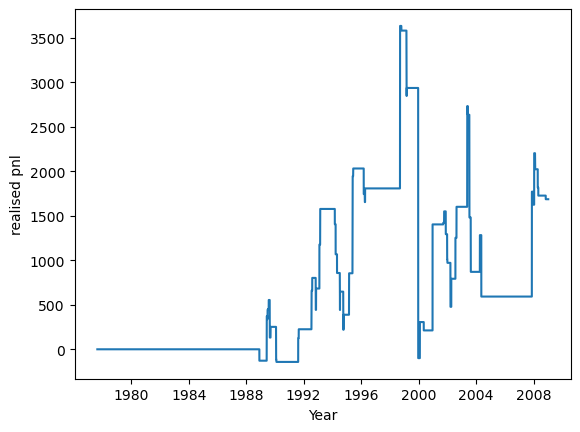

In [ ]:
#plot cumultive plot
portfolio.plotcumpnl()

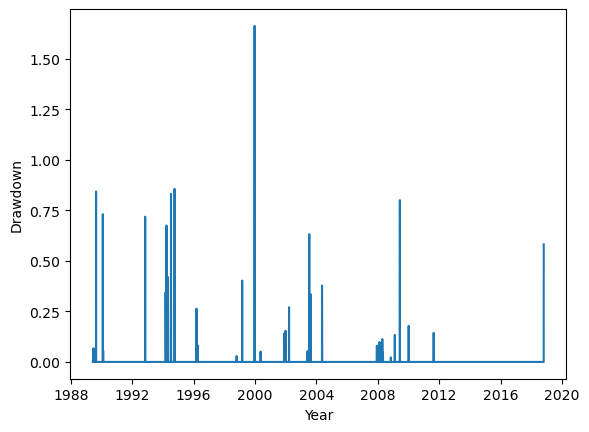

In [ ]:
#compute drawdown
portfolio.plotdrawdown()